# **Dependencias**

In [ ]:
 # librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/juanse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/juanse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix

from scipy import stats as st

from nltk.stem import SnowballStemmer

from statistics import mode

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
import re

# **Carga de datos**

In [ ]:
import os

current_directory = os.getcwd()
current_directory

'/Users/juanse/Documents/BI/Proyectos/Etapa1/Notebooks/Preprocesamiento'

In [ ]:
ruta = "./../../DatosBrutos/tipo2_entrenamiento_estudiantes.csv"

In [ ]:
data=pd.read_csv(ruta, sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t, data_v = train_test_split(data, test_size=0.2, random_state=0)

In [ ]:
data_t

,Review,Class
6115,"El servicio impecable, las albercas con agua t...",4
6123,Cuando vas de vacaciones a la playa esperas po...,2
6813,No es lo mejor pero obligadamente tenes que ir...,4
5058,Para ser la principal atracción o al menos ser...,3
7280,"La catedral, situada en la plaza principal, va...",3
...,...,...
4931,"Muy delicioso, excelente atención, buen servic...",4
3264,muchísimo calorrrrrrrr....realmente agobiante....,4
1653,Ubicado muy cerca de la ciudad amurallada por ...,5
2607,Una exposición de la comida Regiomontana moder...,5


# **Parte 1: Entendimiento de los datos**

In [ ]:
#Dimensiones
data_t.shape

(6300, 2)

Hay 7875 datos con 1 variable (el texto bruto)

## Unicidad

In [ ]:
#Veamos el numero de datos repetidos
data_t.duplicated(keep = False).sum()

68

Hay problemas de unicidad, ya que hay 102 datos duplicados

## Completitud

In [ ]:
#Veamos cuantos datos faltantes hay
data_t.isna().sum() / data_t.shape[0]

Review    0.0
Class     0.0
dtype: float64

No hay problemas de completitud pues hay 0 datos faltantes

## Consistencia

In [ ]:
#Solo toca revisar que no haya ninguna calificacion que no este entre 1-5
data_t.value_counts(data_t['Class'])

Class
5    1917
4    1547
3    1259
2     951
1     626
Name: count, dtype: int64

No se evidencian problemas de consistencia

## **Entendimiento más profundo de los datos**

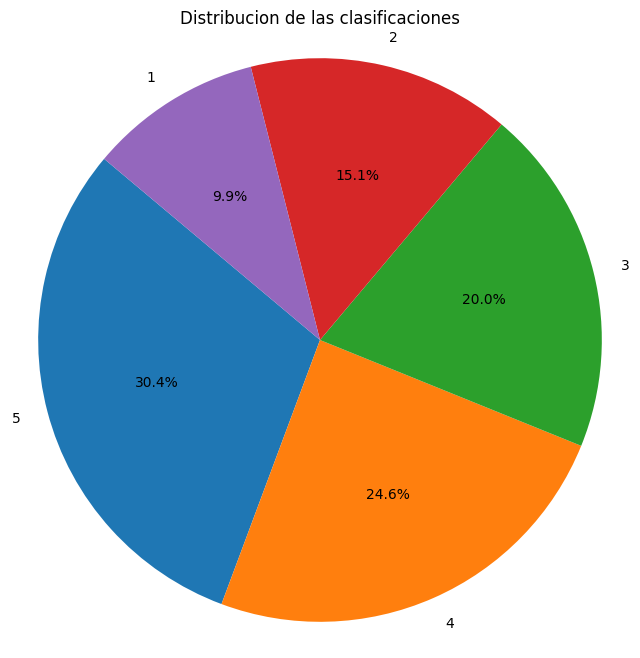

In [ ]:
#Veamos la distribucion de las clasificaciones
# Plotting the pie chart
value_counts = data_t.value_counts(data_t['Class'])
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribucion de las clasificaciones')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Estadisticas descriptivas de los textos

In [ ]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [mode([len(x) for x in i.split(' ')]) for i in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]

In [ ]:
textos

,Review,Class,Conteo,Moda,Max,Min
6115,"El servicio impecable, las albercas con agua t...",4,518,2,15,1
6123,Cuando vas de vacaciones a la playa esperas po...,2,716,2,11,1
6813,No es lo mejor pero obligadamente tenes que ir...,4,110,2,13,1
5058,Para ser la principal atracción o al menos ser...,3,530,2,10,1
7280,"La catedral, situada en la plaza principal, va...",3,193,2,15,1
...,...,...,...,...,...,...
4931,"Muy delicioso, excelente atención, buen servic...",4,101,9,11,1
3264,muchísimo calorrrrrrrr....realmente agobiante....,4,526,2,34,0
1653,Ubicado muy cerca de la ciudad amurallada por ...,5,325,2,10,1
2607,Una exposición de la comida Regiomontana moder...,5,301,2,19,1


# **Parte 2: Preparacion de los datos**

In [ ]:
#Primero eliminamos los datos duplicados
df_procesado = data_t.copy()
df_procesado = df_procesado.drop_duplicates()

In [ ]:
df_procesado.shape

(6254, 2)

### Funciones de limpieza

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = word.lower()
            if new_word != ' ':
                new_words.append(new_word)
    return new_words


def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isnumeric():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def contains_number(s):
    # Regular expression pattern to match any digit
    pattern = re.compile(r'\d')
    return bool(pattern.search(s))

def remove_numbers(words):
    new_words = []
    for word in words:
        if not contains_number(word):
            new_words.append(word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            # Adjusted regular expression pattern to exclude colon
            new_word = re.sub(r'[^\w\s:]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

spanish_stopwords = set(stopwords.words('spanish'))
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word is not None:
            if word not in spanish_stopwords:
                new_words.append(word)
    return new_words

#Esta version solo convierte a minusculas y quita puntuacion
def preprocessing(words):
    words = to_lowercase(words)
 #   words = replace_numbers(words)
    words = remove_punctuation(words)
#    words = remove_non_ascii(words)
#    words = remove_stopwords(words)
    return words

#Esta version elimina convierte a misnusculas, quita puntuacion, quita stopwords
def preprocessing2(words):
    words = to_lowercase(words)
    words = remove_numbers(words)
    words = remove_punctuation(words)
   # words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### Deberiamos eliminar las stopwords?
Primero miremos el conjunto de palabras categorizadas como Stopwords en el idioma Español.

In [ ]:
spanish_stopwords

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

Usando sentido comun, pareciera que no hay palabras asi que tengan mucho sentido orientado a expresar una buena o mala experiencia, como equipo, consideramos útil quitarlas.

## **Tokenizacion**

In [ ]:
#Aplica la corrección de las contracciones (como se ve en el resultado, no tiene efecto alguno en realidad)
review_antes = df_procesado['Review'].loc[600]
df_procesado['Review'] = df_procesado['Review'].apply(contractions.fix)
review_despues = df_procesado['Review'].loc[600]

len(review_antes)-len(review_despues)

0

No eliminó ninguna contracción.

In [ ]:
#Tokens
df_procesado['words'] = df_procesado['Review'].apply(word_tokenize)

In [ ]:
df_procesado.head()

,Review,Class,words
6115,"El servicio impecable, las albercas con agua t...",4,"[El, servicio, impecable, ,, las, albercas, co..."
6123,Cuando vas de vacaciones a la playa esperas po...,2,"[Cuando, vas, de, vacaciones, a, la, playa, es..."
6813,No es lo mejor pero obligadamente tenes que ir...,4,"[No, es, lo, mejor, pero, obligadamente, tenes..."
5058,Para ser la principal atracción o al menos ser...,3,"[Para, ser, la, principal, atracción, o, al, m..."
7280,"La catedral, situada en la plaza principal, va...",3,"[La, catedral, ,, situada, en, la, plaza, prin..."


In [ ]:
df_procesado['words'].dropna()

6115    [El, servicio, impecable, ,, las, albercas, co...
6123    [Cuando, vas, de, vacaciones, a, la, playa, es...
6813    [No, es, lo, mejor, pero, obligadamente, tenes...
5058    [Para, ser, la, principal, atracción, o, al, m...
7280    [La, catedral, ,, situada, en, la, plaza, prin...
                              ...                        
4931    [Muy, delicioso, ,, excelente, atención, ,, bu...
3264    [muchísimo, calorrrrrrrr, ...., realmente, ago...
1653    [Ubicado, muy, cerca, de, la, ciudad, amuralla...
2607    [Una, exposición, de, la, comida, Regiomontana...
2732    [Que, fuimos, a, donde, celebrar, nuestro, ani...
Name: words, Length: 6254, dtype: object

In [ ]:
df_procesado.shape

(6254, 3)

In [ ]:
#Ahora apliquemos la reduccion de ruido (dos versiones distintas)
df_procesado['words1']=df_procesado['words'].apply(preprocessing)
df_procesado['words2']=df_procesado['words'].apply(preprocessing2)

In [ ]:
df_procesado.head()

,Review,Class,words,words1,words2
6115,"El servicio impecable, las albercas con agua t...",4,"[El, servicio, impecable, ,, las, albercas, co...","[el, servicio, impecable, las, albercas, con, ...","[servicio, impecable, albercas, agua, templada..."
6123,Cuando vas de vacaciones a la playa esperas po...,2,"[Cuando, vas, de, vacaciones, a, la, playa, es...","[cuando, vas, de, vacaciones, a, la, playa, es...","[vas, vacaciones, playa, esperas, poder, mar, ..."
6813,No es lo mejor pero obligadamente tenes que ir...,4,"[No, es, lo, mejor, pero, obligadamente, tenes...","[no, es, lo, mejor, pero, obligadamente, tenes...","[mejor, obligadamente, tenes, ir, tomarte, esc..."
5058,Para ser la principal atracción o al menos ser...,3,"[Para, ser, la, principal, atracción, o, al, m...","[para, ser, la, principal, atracción, o, al, m...","[ser, principal, atracción, menos, ser, catalo..."
7280,"La catedral, situada en la plaza principal, va...",3,"[La, catedral, ,, situada, en, la, plaza, prin...","[la, catedral, situada, en, la, plaza, princip...","[catedral, situada, plaza, principal, vale, pe..."


Debido a que con la tabla anterior no se logra ver bien el efecto de los distintos procesamientos, nos preguntamos: **¿Vale la pena los pasos de limpieza extra?**

In [ ]:
#Veamos cuantas filas sirvio quitar stopwords
cantidad = 0

for i in df_procesado['words'].index:
    longitud_con = len(df_procesado['words1'].loc[i])
    longitud_sin = len(df_procesado['words2'].loc[i])
    if longitud_con != longitud_sin:
        cantidad = cantidad + 1

cantidad

6251

En casi todas las filas se eliminaron stopwords, entonces vale la pena utilizar el preprocesamiento 2 construído anteriormente.

## **Normalizacion**

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    # Initialize SnowballStemmer for Spanish
    stemmer = SnowballStemmer(language='spanish')
    # Stem each word in the list
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    #stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
#    return stems + lemmas
    return lemmas

In [ ]:
#Aplica lematización
df_procesado['words3'] = df_procesado['words2'].apply(stem_and_lemmatize) 
df_procesado.head()

,Review,Class,words,words1,words2,words3
6115,"El servicio impecable, las albercas con agua t...",4,"[El, servicio, impecable, ,, las, albercas, co...","[el, servicio, impecable, las, albercas, con, ...","[servicio, impecable, albercas, agua, templada...","[servicio, impecable, albercas, agua, templada..."
6123,Cuando vas de vacaciones a la playa esperas po...,2,"[Cuando, vas, de, vacaciones, a, la, playa, es...","[cuando, vas, de, vacaciones, a, la, playa, es...","[vas, vacaciones, playa, esperas, poder, mar, ...","[vas, vacaciones, playa, esperas, poder, mar, ..."
6813,No es lo mejor pero obligadamente tenes que ir...,4,"[No, es, lo, mejor, pero, obligadamente, tenes...","[no, es, lo, mejor, pero, obligadamente, tenes...","[mejor, obligadamente, tenes, ir, tomarte, esc...","[mejor, obligadamente, tenes, ir, tomarte, esc..."
5058,Para ser la principal atracción o al menos ser...,3,"[Para, ser, la, principal, atracción, o, al, m...","[para, ser, la, principal, atracción, o, al, m...","[ser, principal, atracción, menos, ser, catalo...","[ser, principal, atracción, menos, ser, catalo..."
7280,"La catedral, situada en la plaza principal, va...",3,"[La, catedral, ,, situada, en, la, plaza, prin...","[la, catedral, situada, en, la, plaza, princip...","[catedral, situada, plaza, principal, vale, pe...","[catedral, situada, plaza, principal, vale, pe..."


**Nuevamente queremos averiguar si valio la pena la trasnformacion hecha.**

In [ ]:
#Veamos cuantas filas sirvio usar lemas
cantidad = 0

for i in df_procesado['words'].index:
    longitud_con = len(df_procesado['words2'].loc[i])
    longitud_sin = len(df_procesado['words3'].loc[i])
    if longitud_con != longitud_sin:
        cantidad = cantidad + 1

cantidad

0

Usar lemas no fue de utilidad en este caso.

### Seleccion de campos

In [ ]:
df_procesado['words2'] = df_procesado['words2'].apply(lambda x: ' '.join(map(str, x)))
df_procesado

,Review,Class,words,words1,words2,words3
6115,"El servicio impecable, las albercas con agua t...",4,"[El, servicio, impecable, ,, las, albercas, co...","[el, servicio, impecable, las, albercas, con, ...",servicio impecable albercas agua templada comi...,"[servicio, impecable, albercas, agua, templada..."
6123,Cuando vas de vacaciones a la playa esperas po...,2,"[Cuando, vas, de, vacaciones, a, la, playa, es...","[cuando, vas, de, vacaciones, a, la, playa, es...",vas vacaciones playa esperas poder mar si lleg...,"[vas, vacaciones, playa, esperas, poder, mar, ..."
6813,No es lo mejor pero obligadamente tenes que ir...,4,"[No, es, lo, mejor, pero, obligadamente, tenes...","[no, es, lo, mejor, pero, obligadamente, tenes...",mejor obligadamente tenes ir tomarte escuchar ...,"[mejor, obligadamente, tenes, ir, tomarte, esc..."
5058,Para ser la principal atracción o al menos ser...,3,"[Para, ser, la, principal, atracción, o, al, m...","[para, ser, la, principal, atracción, o, al, m...",ser principal atracción menos ser catalogada a...,"[ser, principal, atracción, menos, ser, catalo..."
7280,"La catedral, situada en la plaza principal, va...",3,"[La, catedral, ,, situada, en, la, plaza, prin...","[la, catedral, situada, en, la, plaza, princip...",catedral situada plaza principal vale pena pas...,"[catedral, situada, plaza, principal, vale, pe..."
...,...,...,...,...,...,...
4931,"Muy delicioso, excelente atención, buen servic...",4,"[Muy, delicioso, ,, excelente, atención, ,, bu...","[muy, delicioso, excelente, atención, buen, se...",delicioso excelente atención buen servicio sir...,"[delicioso, excelente, atención, buen, servici..."
3264,muchísimo calorrrrrrrr....realmente agobiante....,4,"[muchísimo, calorrrrrrrr, ...., realmente, ago...","[muchísimo, calorrrrrrrr, realmente, agobiante...",muchísimo calorrrrrrrr realmente agobiante val...,"[muchísimo, calorrrrrrrr, realmente, agobiante..."
1653,Ubicado muy cerca de la ciudad amurallada por ...,5,"[Ubicado, muy, cerca, de, la, ciudad, amuralla...","[ubicado, muy, cerca, de, la, ciudad, amuralla...",ubicado cerca ciudad amurallada dolares taxi d...,"[ubicado, cerca, ciudad, amurallada, dolares, ..."
2607,Una exposición de la comida Regiomontana moder...,5,"[Una, exposición, de, la, comida, Regiomontana...","[una, exposición, de, la, comida, regiomontana...",exposición comida regiomontana modernizada pro...,"[exposición, comida, regiomontana, modernizada..."


Procedemos a hacer la separacion de los datos en X y en Y

In [ ]:
X_data, y_data = df_procesado['words2'],df_procesado['Class']
y_data

6115    4
6123    2
6813    4
5058    3
7280    3
       ..
4931    4
3264    4
1653    5
2607    5
2732    5
Name: Class, Length: 6254, dtype: int64

Primero creamos la primera version de los datos en representacion de BoW

In [ ]:
# Creamos el contador
count = CountVectorizer()

# Creamos la bolsa de palabras
X_count = count.fit_transform(X_data)

# Sacamos los nombres de las columnas
feature_names = count.get_feature_names_out()


### Exportamos

In [ ]:
#Exportamos X
# Create DataFrame from transformed data
df_x = pd.DataFrame(X_count.toarray(), columns=feature_names)
df_x.shape

(6254, 23158)

In [ ]:
#Esta es la version del DF con todo lo que lanza el prepocesamiento normal
#df_x.to_csv('./../../DatosProcesados/X_train_V1.csv', index=False)

**Problema**: Se ve que hay casi 4 veces mas columnas que datos, es un signo claro de muy alta dimensionalidad.

**Soluciona**: Vamos a eliminar aquellas columnas que correspondan a palabras con una sola aparición, debido a la baja relevancia que pueden tener dentro del modelo.

In [ ]:
#Sacamos la lista de los features (palabras con mas de 1 aparición)
utiles = []
for feature in feature_names:
    cuenta_mayores = (df_x[feature] != 0).sum()
    if cuenta_mayores > 1:
        utiles.append(feature)

len(utiles)

10692

Ahora tenemos muchas menos palabras para considerar, lo que puede llegar a mejorar el desempeño de algunos algoritmos. A prtir de esto ya se puede hacer la exportacion de X,Y train y las transformaciones para test y unlabeled data

In [ ]:
df_x_v2 = df_x[utiles].copy()
#df_x_v2.to_csv('./../../DatosProcesados/X_train_V3.csv', index=False)

In [ ]:
#Exportamos Y
df_y = pd.DataFrame({'Class': y_data})

# Export the DataFrame to a CSV file
df_y.to_csv('./../../DatosProcesados/Entrenamiento/Y_train_V1.csv', index=False)

Aplicamos las mismas transformaciones a validation

In [ ]:
val_procesado = data_v.copy()
val_procesado['Review'] = val_procesado['Review'].apply(contractions.fix)
#Tokens
val_procesado['words'] = val_procesado['Review'].apply(word_tokenize)
val_procesado['words1']=val_procesado['words'].apply(preprocessing2)
val_procesado['words1'] = val_procesado['words1'].apply(lambda x: ' '.join(map(str, x)))
X_data_v, y_data_v = val_procesado['words1'],val_procesado['Class']

In [ ]:
#Ajustamos X data a la matriz otra
X_v_count = count.transform(X_data_v)
X_v_count.shape

(1575, 23158)

In [ ]:
#Esta matriz todavia tiene todas las variables iniciales, entonces creamos el df con todas
df_x_val = pd.DataFrame(X_v_count.toarray(), columns=feature_names)

#Ahora solo utilizamos las columnas anteriores
df_x_val_v1 = df_x_val[utiles].copy()

In [ ]:
#Exportamos x_validation, y_validation
#Exportamos Y
df_y_val = pd.DataFrame({'Class': y_data_v})
df_y_val.to_csv('./../../DatosProcesados/ValidationTest/Y_validation_V1.csv', index=False)

#Exportamos X
df_x_val_v1.to_csv('./../../DatosProcesados/ValidationTest/X_validation_V1.csv', index=False)

In [ ]:
#Ahora podemos hacer lo mismo para los datos unlabeled
unlabeled_df = pd.read_csv('./../../DatosBrutos/particion_prueba_estudiantes.csv', sep=',', encoding = 'utf-8')
unlabedled_procesado = unlabeled_df.copy()
unlabedled_procesado['Review'] = unlabedled_procesado['Review'].apply(contractions.fix)
#Tokens
unlabedled_procesado['words'] = unlabedled_procesado['Review'].apply(word_tokenize)
unlabedled_procesado['words1']=unlabedled_procesado['words'].apply(preprocessing2)
unlabedled_procesado['words1'] = unlabedled_procesado['words1'].apply(lambda x: ' '.join(map(str, x)))
X_data_unlabeled = unlabedled_procesado['words1']

In [ ]:
#Ajustamos X data a la matriz otra
X_unlabeled = count.transform(X_data_unlabeled)
X_unlabeled.shape

(1750, 23158)

In [ ]:
#Esta matriz todavia tiene todas las variables iniciales, entonces creamos el df con todas
df_x_unlabeled = pd.DataFrame(X_unlabeled.toarray(), columns=feature_names)

#Ahora solo utilizamos las columnas anteriores
df_un_v1 = df_x_unlabeled[utiles].copy()

In [ ]:
#Exportamos X_unlabeled
df_un_v1.to_csv('./../../DatosProcesados/Unlabeled/X_unlabeled_V1.csv', index=False)